# Introduction


Project:Building a Hit and Run classifier for injury resulting  accidents.  According to the chicago traffic data, hit and run accidents account for the highest cause of accidents over the past 7 years. In this analysis im specifically looking at the Hit and run accidents that resulted in injuries. The goal of this analysis is to help the vehicle safety board with meaningfull insights so that they can take necessary measures to reduce hit and run accidents and make the roads safer for its residents.


In [4]:
# Importing libraries 
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold,cross_val_score
from numpy import mean
from numpy import std
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
%matplotlib inline
import seaborn as sns


C:\Users\Laurel\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Laurel\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Laurel\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  d

In [5]:
def get_metrics(test, pred):
    """Pass (y_test,y_predicted) to get F1,Accuracy and ROC_AUC"""
    print("F1 Score: {}".format(f1_score(test, pred, average= 'weighted')))
    print(f'Accuracy Score Test: {accuracy_score(test, pred)}')
    print(f'ROC_AUC Test: {roc_auc_score(test, pred)}')
    

In [6]:
def bargraph (xColumn,yColumn,str):
    """Bar graph using sns (x,y,Title string)"""
    plt.figure(figsize=(10,10))
    ax=sns.barplot(y=yColumn,x=xColumn)
    plt.title(str,weight='bold').set_fontsize('25')
    plt.ylabel("Type of Accident", size=20, rotation=90)
    plt.xlabel("Number of accidents", size=20)
    plt.xticks(size=15)
    plt.yticks(size=15)
    

In [45]:
def annot_percent(plot, feature, Number_of_categories, hue_categories,h):
    """annotate % on bar graphs with hue, plot,len of data,hue categories, h=1 for horizontal bar,h!=1 is vertical """
    if h == 1:
        a = [p.get_width() for p in plot.patches]
        patch = [p for p in plot.patches]
        for i in range(Number_of_categories):
            total = feature.value_counts().values[i]
            for j in range(hue_categories):
                percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
                x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width()
                y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
                ax.annotate(percentage, (x, y), size = 12)
        plt.show()
    else:
        a = [p.get_height() for p in plot.patches]
        patch = [p for p in plot.patches]
        for i in range(Number_of_categories):
            total = feature.value_counts().values[i]
            for j in range(hue_categories):
                percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
                x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() /2-0.15
                y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
                ax.annotate(percentage, (x, y))
        plt.show()

# Data Exploration

In [8]:
df_clean = pd.read_csv('Data/Clean_data_all')

In [9]:
df_clean.head()

,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,ALIGNMENT,ROAD_DEFECT,CRASH_TYPE,...,HIT_AND_RUN_I,DOLLAR_DAMAGE,PRIM_CONTRIBUTORY_CAUSE,NUM_UNITS,INJURY_TYPE,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
0,35,SIGN,FUNCTIONAL,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,1,0,1,...,0,OVER 1500,FAILING TO YIELD RIGHT-OF-WAY,2,NO INDICATION OF INJURY,16,6,6,41.741804,-87.740954
1,30,SIGNAL,FUNCTIONAL,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,1,0,0,...,0,OVER 1500,IMPROPER OVERTAKING/PASSING,2,NO INDICATION OF INJURY,17,5,8,41.903825,-87.643286
2,25,NO CONTROLS,NO CONTROLS,RAIN,DAYLIGHT,ANGLE,NOT DIVIDED,1,0,0,...,0,OVER 1500,FAILING TO YIELD RIGHT-OF-WAY,2,NO INDICATION OF INJURY,11,4,5,41.721290,-87.628510
3,30,SIGN,FUNCTIONAL,CLEAR,DAYLIGHT,REAR END,ONE-WAY,1,0,0,...,1,501 - 1500,IMPROPER BACKING,2,NO INDICATION OF INJURY,18,5,5,41.907777,-87.634531
4,20,SIGNAL,FUNCTIONAL,CLEAR,DAYLIGHT,PEDESTRIAN,NOT DIVIDED,1,0,0,...,0,500 OR LESS,DISTRACTION - FROM INSIDE VEHICLE,2,NO INDICATION OF INJURY,15,3,12,41.954196,-87.669193


In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312611 entries, 0 to 312610
Data columns (total 22 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   POSTED_SPEED_LIMIT       312611 non-null  int64  
 1   TRAFFIC_CONTROL_DEVICE   312611 non-null  object 
 2   DEVICE_CONDITION         312611 non-null  object 
 3   WEATHER_CONDITION        312611 non-null  object 
 4   LIGHTING_CONDITION       312611 non-null  object 
 5   FIRST_CRASH_TYPE         312611 non-null  object 
 6   TRAFFICWAY_TYPE          312611 non-null  object 
 7   ALIGNMENT                312611 non-null  int64  
 8   ROAD_DEFECT              312611 non-null  int64  
 9   CRASH_TYPE               312611 non-null  int64  
 10  INTERSECTION_RELATED_I   312611 non-null  int64  
 11  NOT_RIGHT_OF_WAY_I       312611 non-null  int64  
 12  HIT_AND_RUN_I            312611 non-null  int64  
 13  DOLLAR_DAMAGE            312611 non-null  object 
 14  PRIM

In [11]:
df_clean['PRIM_CONTRIBUTORY_CAUSE'].value_counts()

UNKNOWN_HR                                                                          72278
FAILING TO YIELD RIGHT-OF-WAY                                                       50956
FOLLOWING TOO CLOSELY                                                               49380
IMPROPER OVERTAKING/PASSING                                                         21873
IMPROPER BACKING                                                                    20281
FAILING TO REDUCE SPEED TO AVOID CRASH                                              19853
IMPROPER LANE USAGE                                                                 18057
IMPROPER TURNING/NO SIGNAL                                                          15320
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                 14842
DISREGARDING TRAFFIC SIGNALS                                                         8188
WEATHER                                                                              7415
OPERATING 

## Exploring all accidents

Since one of the goals of this analysis is to provide the city of chicago with meaningfull patterns i wanted to look at the top 10 most occuring accidents 

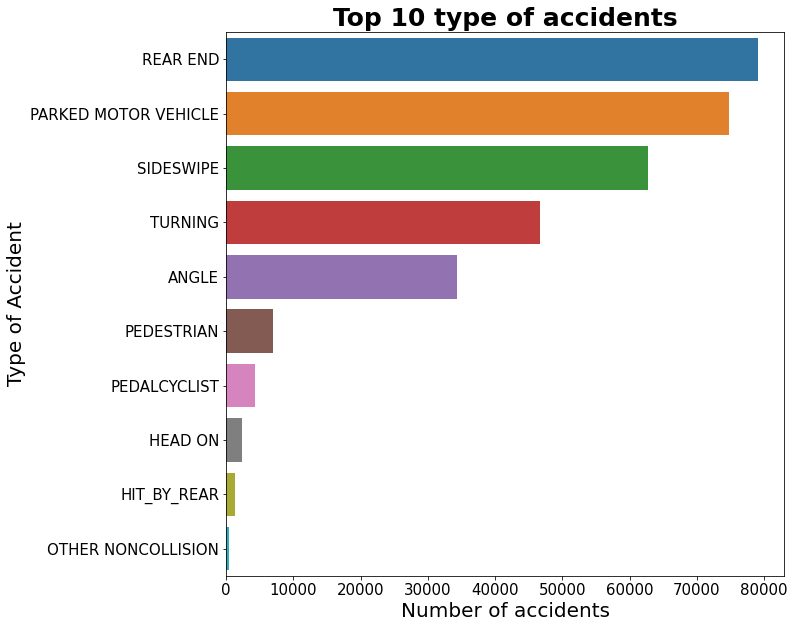

In [12]:
#look at the top 10 accidents based on number of accidents 
y= df_clean.FIRST_CRASH_TYPE.value_counts().values[:10]
x=df_clean.FIRST_CRASH_TYPE.value_counts().index[:10]
bargraph(y,x,'Top 10 type of accidents')

Bsed on this graph above Seems like the top 5 type of accidents account for most of the accidents .,Lets see how much do these accidents account for cumulatively  relative to the total number of accidents . 

In [13]:
a= len(df_clean.FIRST_CRASH_TYPE.unique())
print("All accidents stats")
for i in range(1,a+1):
    y= df_clean.FIRST_CRASH_TYPE.value_counts().values[:i].sum() 
    print("The top",i,"type of acidents account for",round(y*100/len(df_clean.FIRST_CRASH_TYPE),2),
      "% of accidents")

All accidents stats
The top 1 type of acidents account for 25.28 % of accidents
The top 2 type of acidents account for 49.17 % of accidents
The top 3 type of acidents account for 69.24 % of accidents
The top 4 type of acidents account for 84.17 % of accidents
The top 5 type of acidents account for 95.16 % of accidents
The top 6 type of acidents account for 97.38 % of accidents
The top 7 type of acidents account for 98.74 % of accidents
The top 8 type of acidents account for 99.47 % of accidents
The top 9 type of acidents account for 99.88 % of accidents
The top 10 type of acidents account for 100.0 % of accidents


Seems the top 5 accidents account for about 95% of the accidents.

Lets look at the causes of  accidents

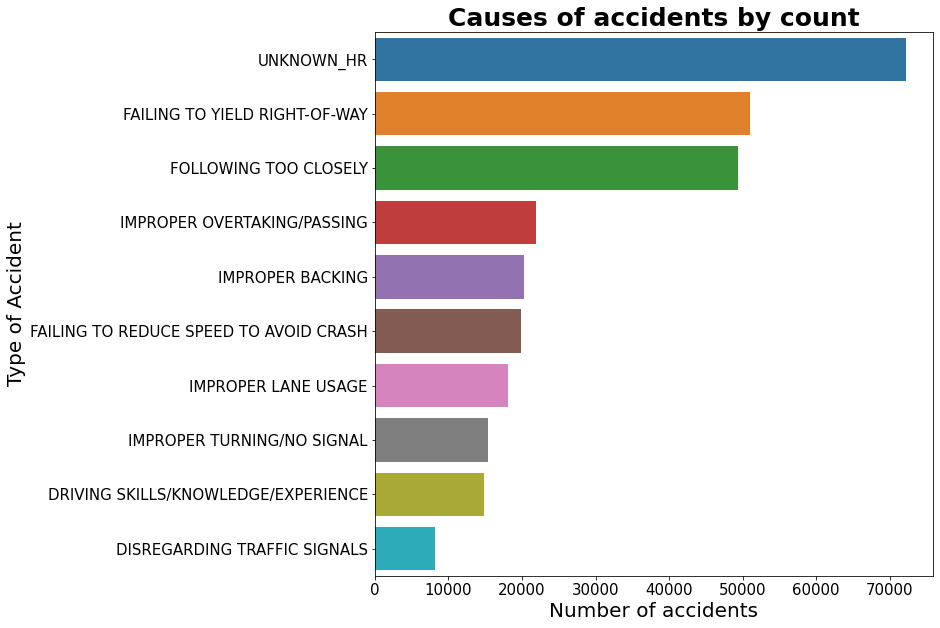

In [14]:
#look at causes of accidents based on number of accidents 
y= df_clean.PRIM_CONTRIBUTORY_CAUSE.value_counts().values[:10]
x=df_clean.PRIM_CONTRIBUTORY_CAUSE.value_counts().index[:10]
bargraph(y,x,'Causes of accidents by count')

Seems like the top 10 causes account for the majority of accidents and Hit and Run accounts for the most cause resulting in 23% of the accidents. (nearly a quarter yikes!)

In [15]:
a= len(df_clean.PRIM_CONTRIBUTORY_CAUSE.unique())
print("All accidents stats")
for i in range(1,a+1):
    y= df_clean.PRIM_CONTRIBUTORY_CAUSE.value_counts().values[:i].sum() 
    print("The top",i,"causes accounts for",round(y*100/len(df_clean.PRIM_CONTRIBUTORY_CAUSE),2),
      "% of accidents")

All accidents stats
The top 1 causes accounts for 23.12 % of accidents
The top 2 causes accounts for 39.42 % of accidents
The top 3 causes accounts for 55.22 % of accidents
The top 4 causes accounts for 62.21 % of accidents
The top 5 causes accounts for 68.7 % of accidents
The top 6 causes accounts for 75.05 % of accidents
The top 7 causes accounts for 80.83 % of accidents
The top 8 causes accounts for 85.73 % of accidents
The top 9 causes accounts for 90.48 % of accidents
The top 10 causes accounts for 93.1 % of accidents
The top 11 causes accounts for 95.47 % of accidents
The top 12 causes accounts for 97.29 % of accidents
The top 13 causes accounts for 98.91 % of accidents
The top 14 causes accounts for 100.0 % of accidents


In [16]:
Top_10_causes = df_clean.PRIM_CONTRIBUTORY_CAUSE.value_counts().index[:10].to_list()
Top_5_causes = df_clean.PRIM_CONTRIBUTORY_CAUSE.value_counts().index[:5].to_list()
Top_3_causes = df_clean.PRIM_CONTRIBUTORY_CAUSE.value_counts().index[:3].to_list()


In [17]:
df_top10_causes = df_clean[df_clean['PRIM_CONTRIBUTORY_CAUSE'].isin(Top_10_causes)]
df_top5_causes = df_clean[df_clean['PRIM_CONTRIBUTORY_CAUSE'].isin(Top_5_causes)]
df_top3_causes = df_clean[df_clean['PRIM_CONTRIBUTORY_CAUSE'].isin(Top_3_causes)]

## Exploring injury resulting accidents 

Since the goal of this analysis is to make roads safer we will be specifically looking at traffic accidents that resulted in injuries 

In [18]:
# New dataframe with accidents that resulted in injuries 
df_injury = df_clean.loc[(df_clean['INJURY_TYPE']!='NO INDICATION OF INJURY')]

In [19]:
df_injury['INJURY_TYPE'].value_counts().index

Index(['NONINCAPACITATING INJURY', 'REPORTED, NOT EVIDENT',
       'INCAPACITATING INJURY', 'FATAL'],
      dtype='object')

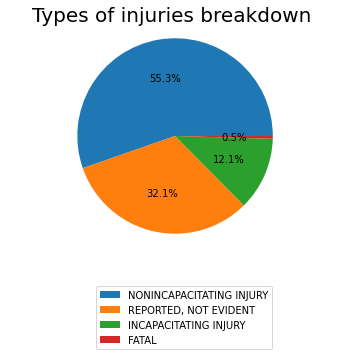

In [20]:
#See the injury breakdown 
df_injury['INJURY_TYPE'].value_counts().plot(kind='pie',labels = None, autopct='%1.1f%%')
plt.axis('equal')
plt.ylabel('')
plt.legend(labels=df_injury['INJURY_TYPE'].value_counts().index , bbox_to_anchor=(0.75,0), loc="best", 
                          bbox_transform=plt.gcf().transFigure)
plt.title('Types of injuries breakdown ',size=20)
plt.show()

In [21]:
# What percent of accidents resulted in injuries 
print(" %.3f percent of accidents resulted in injuries " % (100*df_injury.shape[0]/df_clean.shape[0]))


 12.747 percent of accidents resulted in injuries 


Seems overall about 13% of accidents resulted in injuries  , the majority of these accidents are minor accidents whereas about 12% was serious and 0.5% was fatal

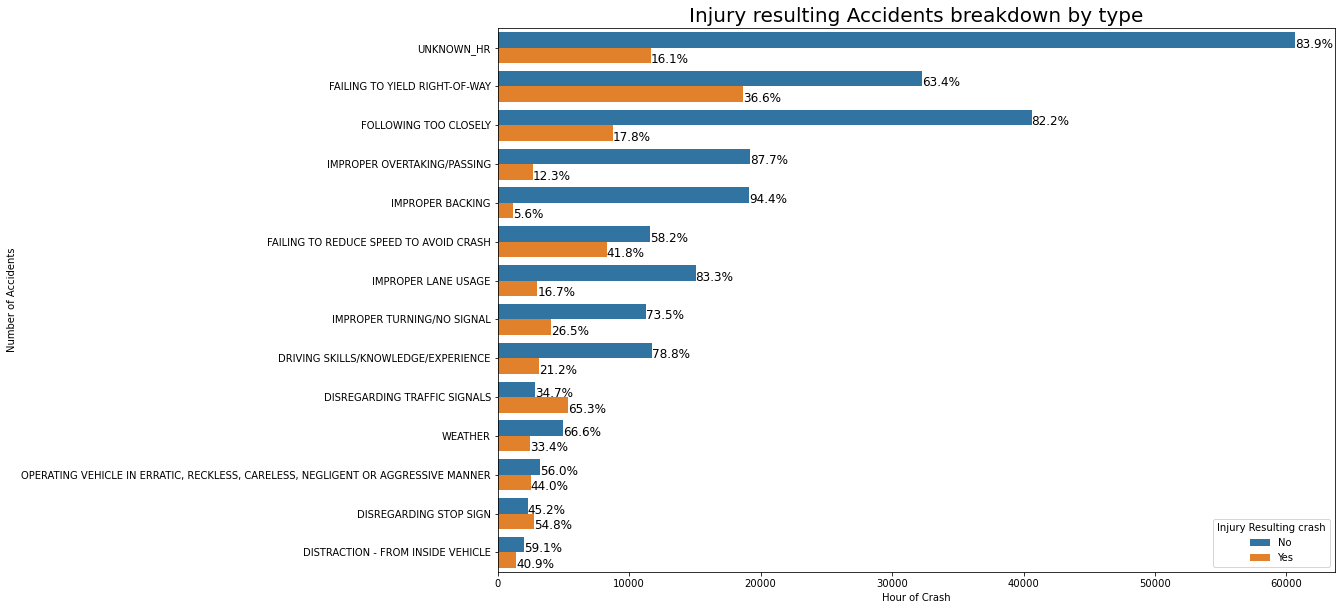

In [22]:
plt.figure(figsize =(15,10))
ax = sns.countplot(y="PRIM_CONTRIBUTORY_CAUSE",hue='CRASH_TYPE',data=df_clean,order =df_clean["PRIM_CONTRIBUTORY_CAUSE"].value_counts().index)
plt.xlabel('Hour of Crash')
plt.ylabel('Number of Accidents')
plt.legend(title='Injury Resulting crash', loc='lower right', labels=['No', 'Yes'])
plt.title('Injury resulting Accidents breakdown by type',size=20)
annot_percent(ax,df_clean.PRIM_CONTRIBUTORY_CAUSE,len(df_clean.PRIM_CONTRIBUTORY_CAUSE.unique()),2,1)

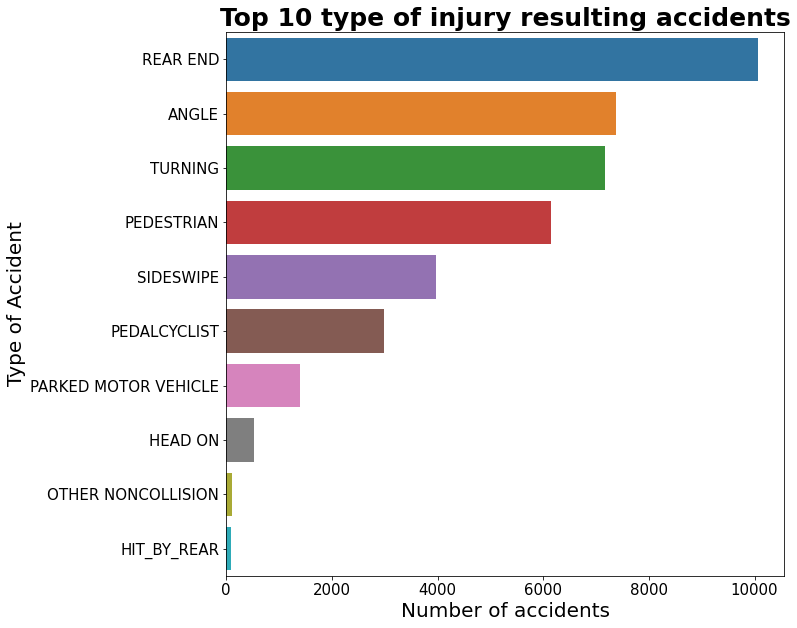

In [23]:
#look at the top 10 injury resulting type of accidents based on number of accidents 
y= df_injury.FIRST_CRASH_TYPE.value_counts().values[:10]
x=df_injury.FIRST_CRASH_TYPE.value_counts().index[:10]
bargraph(y,x,'Top 10 type of injury resulting accidents')

Overall the injury resulting accidents follow the same distribution as accidents in general 

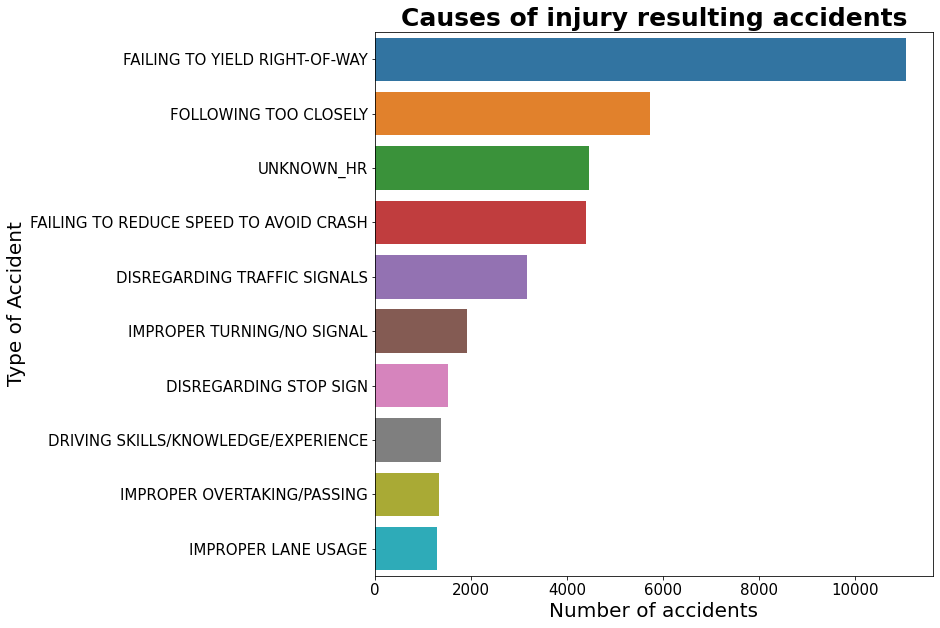

In [24]:
#look at Causus of ijury resulting accidents based on number of accidents 
y= df_injury.PRIM_CONTRIBUTORY_CAUSE.value_counts().values[:10]
x=df_injury.PRIM_CONTRIBUTORY_CAUSE.value_counts().index[:10]
bargraph(y,x,'Causes of injury resulting accidents')

In [25]:
df_injury.PRIM_CONTRIBUTORY_CAUSE.value_counts().index

Index(['FAILING TO YIELD RIGHT-OF-WAY', 'FOLLOWING TOO CLOSELY', 'UNKNOWN_HR',
       'FAILING TO REDUCE SPEED TO AVOID CRASH',
       'DISREGARDING TRAFFIC SIGNALS', 'IMPROPER TURNING/NO SIGNAL',
       'DISREGARDING STOP SIGN', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
       'IMPROPER OVERTAKING/PASSING', 'IMPROPER LANE USAGE',
       'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
       'WEATHER', 'DISTRACTION - FROM INSIDE VEHICLE', 'IMPROPER BACKING'],
      dtype='object')

In [29]:
a= len(df_injury.PRIM_CONTRIBUTORY_CAUSE.unique())
print("All accidents stats")
for i in range(1,a+1):
    y= df_injury.PRIM_CONTRIBUTORY_CAUSE.value_counts().values[:i].sum() 
    print("The top",i,"causes accounts for",round(y*100/len(df_injury.PRIM_CONTRIBUTORY_CAUSE),2),
      "% of injury-resulting accidents")

All accidents stats
The top 1 causes accounts for 27.77 % of injury-resulting accidents
The top 2 causes accounts for 42.17 % of injury-resulting accidents
The top 3 causes accounts for 53.34 % of injury-resulting accidents
The top 4 causes accounts for 64.39 % of injury-resulting accidents
The top 5 causes accounts for 72.35 % of injury-resulting accidents
The top 6 causes accounts for 77.19 % of injury-resulting accidents
The top 7 causes accounts for 81.03 % of injury-resulting accidents
The top 8 causes accounts for 84.48 % of injury-resulting accidents
The top 9 causes accounts for 87.81 % of injury-resulting accidents
The top 10 causes accounts for 91.03 % of injury-resulting accidents
The top 11 causes accounts for 94.03 % of injury-resulting accidents
The top 12 causes accounts for 96.75 % of injury-resulting accidents
The top 13 causes accounts for 98.38 % of injury-resulting accidents
The top 14 causes accounts for 100.0 % of injury-resulting accidents


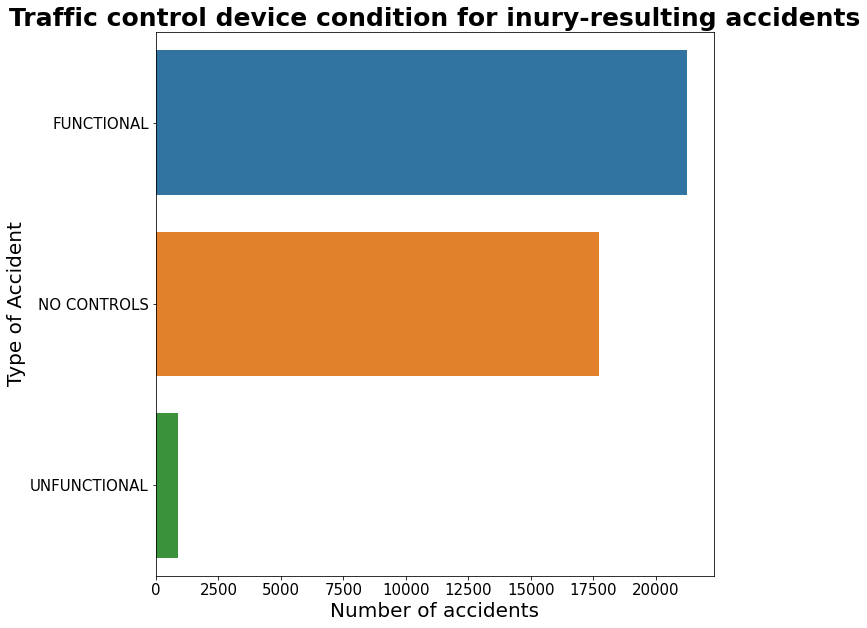

In [30]:
y= df_injury.DEVICE_CONDITION.value_counts().values[:10]
x=df_injury.DEVICE_CONDITION.value_counts().index[:10]
bargraph(y,x,'Traffic control device condition for inury-resulting accidents')

In [31]:
a= len(df_injury.DEVICE_CONDITION.unique())
print("Device stats")
for i in range(0,a):
    y= df_injury.DEVICE_CONDITION.value_counts().values[i] 
    print(round(y*100/len(df_injury.DEVICE_CONDITION),2),"of Traffic control device in inury-resulting accidents was",df_injury.DEVICE_CONDITION.value_counts().index[i],
      )

Device stats
53.36 of Traffic control device in inury-resulting accidents was FUNCTIONAL
44.47 of Traffic control device in inury-resulting accidents was NO CONTROLS
2.17 of Traffic control device in inury-resulting accidents was UNFUNCTIONAL


In [32]:
df_injury['DEVICE_CONDITION'].value_counts()

FUNCTIONAL      21263
NO CONTROLS     17721
UNFUNCTIONAL      863
Name: DEVICE_CONDITION, dtype: int64

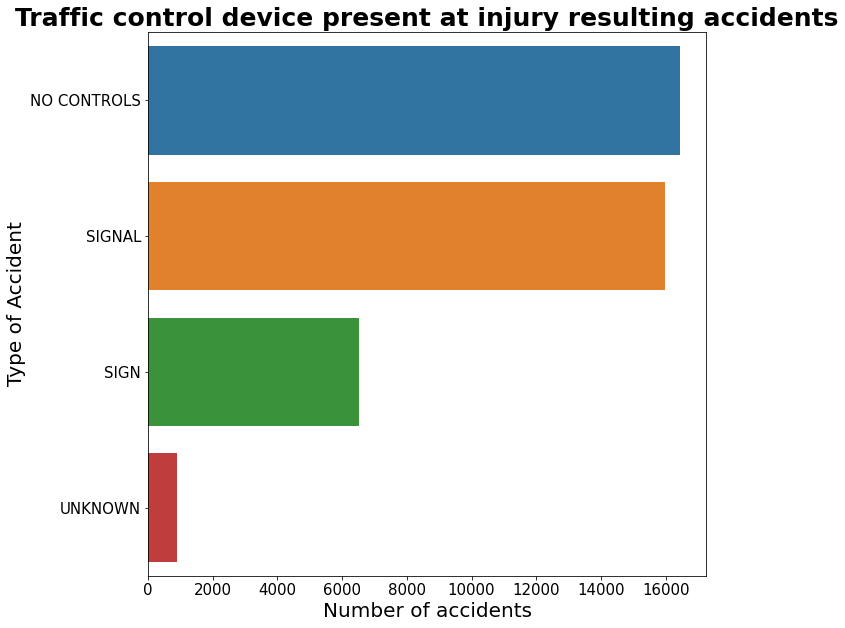

In [33]:
y= df_injury.TRAFFIC_CONTROL_DEVICE.value_counts().values[:10]
x=df_injury.TRAFFIC_CONTROL_DEVICE.value_counts().index[:10]
bargraph(y,x,'Traffic control device present at injury resulting accidents')

In [34]:
a= len(df_injury.TRAFFIC_CONTROL_DEVICE.unique())
print("Device stats")
for i in range(0,a):
    y= df_injury.TRAFFIC_CONTROL_DEVICE.value_counts().values[i] 
    print(round(y*100/len(df_injury.TRAFFIC_CONTROL_DEVICE),2),"of Traffic control device in inury-resulting accidents was",df_injury.TRAFFIC_CONTROL_DEVICE.value_counts().index[i],
      )

Device stats
41.24 of Traffic control device in inury-resulting accidents was NO CONTROLS
40.13 of Traffic control device in inury-resulting accidents was SIGNAL
16.38 of Traffic control device in inury-resulting accidents was SIGN
2.26 of Traffic control device in inury-resulting accidents was UNKNOWN


Leading cause of Injury resulting accidents is failing to yeild right of way wheras hit and run is number 3 

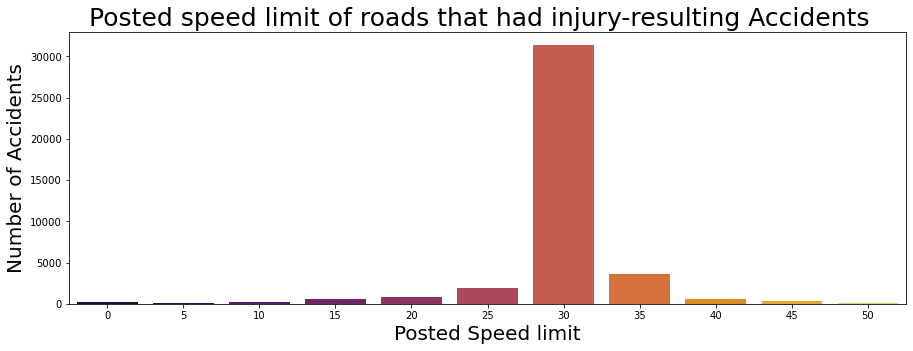

In [35]:
plt.figure(figsize =(15,5))
ax = sns.countplot(x="POSTED_SPEED_LIMIT",data=df_injury,palette='inferno')
plt.xlabel('Posted Speed limit',size=20)
plt.ylabel('Number of Accidents',size=20)
plt.title('Posted speed limit of roads that had injury-resulting Accidents  ',size=25)
plt.show()

Seems most of the injury resulting accidents happen at roads with posted speed limit of 30mph

In [36]:
# What percent of accidents resulted in injuries 
per_Speed=(100*len(df_injury.loc[df_injury['POSTED_SPEED_LIMIT']==30])/df_injury.shape[0])
print(" %.2f percent of injury resulting accidents occured at roads with 30mph posted speed limit. " % per_Speed)


 78.80 percent of injury resulting accidents occured at roads with 30mph posted speed limit. 


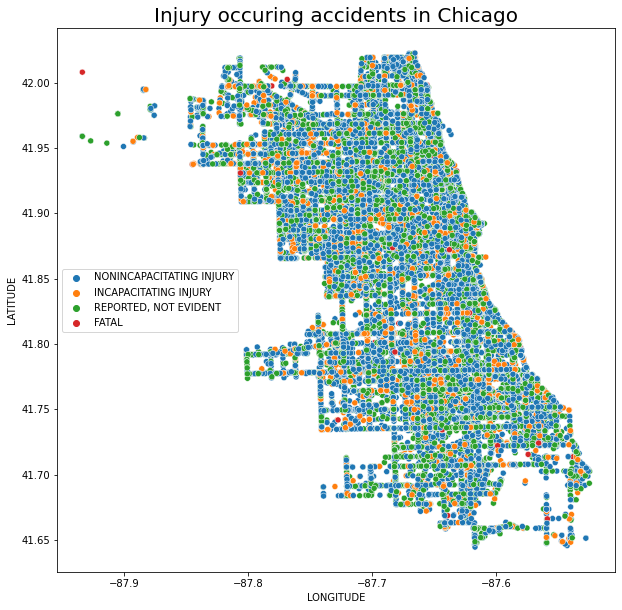

In [37]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='INJURY_TYPE', data=df_injury)
plt.title('Injury occuring accidents in Chicago',size=20)
plt.legend(loc='center left')
plt.show()

There are no specific geographic patterns for injury resulting accidents.

In [38]:
df_clean['CRASH_DAY_OF_WEEK'].value_counts()

6    50693
7    46787
5    44834
3    44233
4    44025
2    43358
1    38681
Name: CRASH_DAY_OF_WEEK, dtype: int64

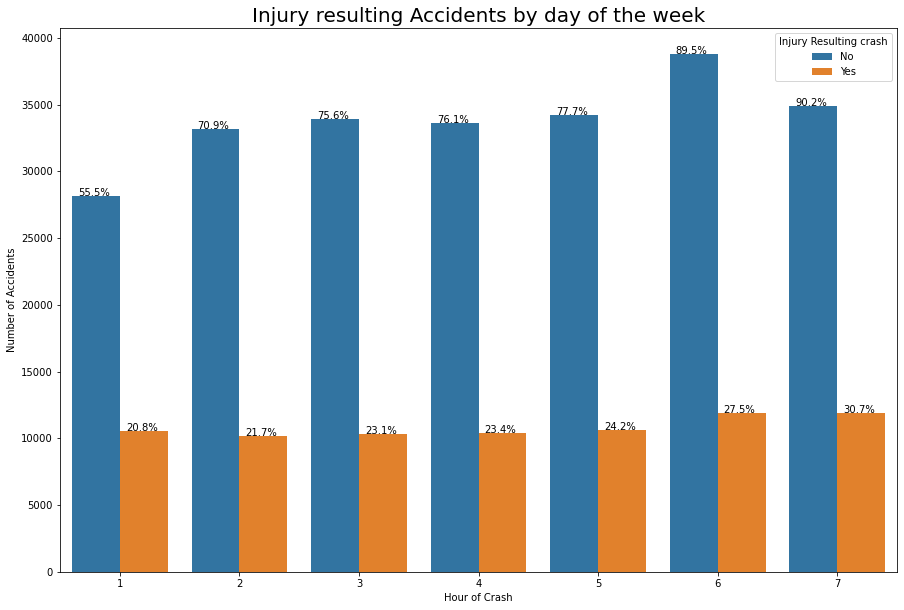

In [46]:
plt.figure(figsize =(15,10))
ax = sns.countplot(x="CRASH_DAY_OF_WEEK",hue='CRASH_TYPE',data=df_clean)
plt.xlabel('Hour of Crash')
plt.ylabel('Number of Accidents')
plt.legend(title='Injury Resulting crash', loc='upper right', labels=['No', 'Yes'])
plt.title('Injury resulting Accidents by day of the week',size=20)
annot_percent(ax,df_clean.CRASH_DAY_OF_WEEK,len(df_clean.CRASH_DAY_OF_WEEK.unique()),2,0)

Weekends have a higher rate of injury resulting accidents then weekdays. Also SAturday has the highest number of accidents.

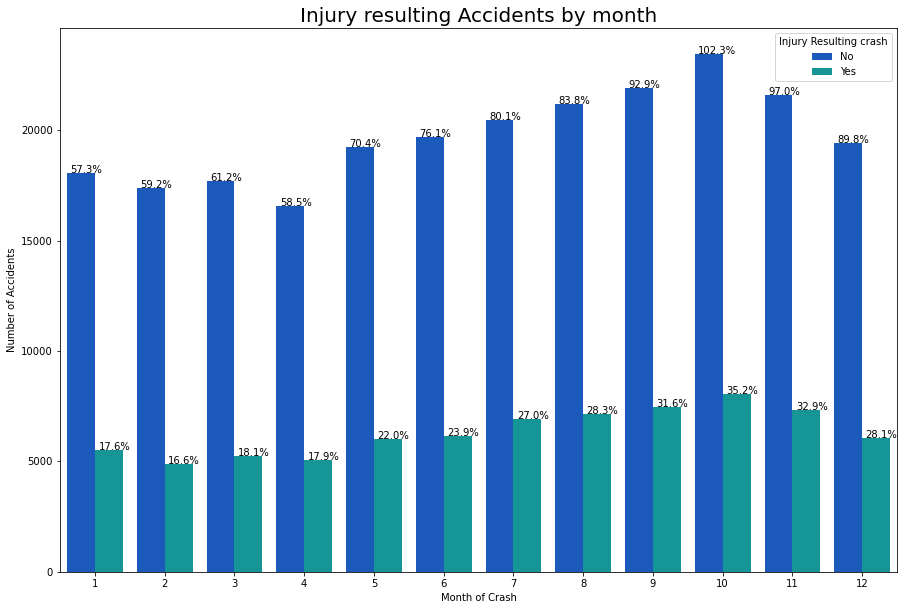

In [60]:
plt.figure(figsize =(15,10))
ax = sns.countplot(x="CRASH_MONTH",hue='CRASH_TYPE',data=df_clean,palette='winter')
plt.xlabel('Month of Crash')
plt.ylabel('Number of Accidents')
plt.legend(title='Injury Resulting crash', loc='upper right', labels=['No', 'Yes'])
plt.title('Injury resulting Accidents by month',size=20)
annot_percent(ax,df_clean.CRASH_MONTH,len(df_clean.CRASH_MONTH.unique()),2,0)

October has the higher rate of injury resulting accidents and the highest number of accidents 

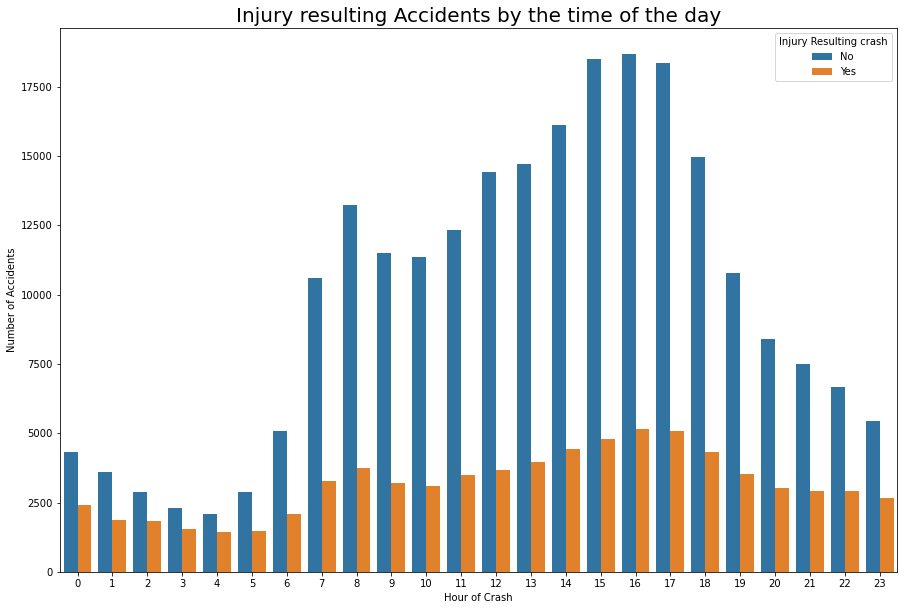

In [63]:
plt.figure(figsize =(15,10))
ax = sns.countplot(x="CRASH_HOUR",hue='CRASH_TYPE',data=df_clean)
plt.xlabel('Hour of Crash')
plt.ylabel('Number of Accidents')
plt.legend(title='Injury Resulting crash', loc='upper right', labels=['No', 'Yes'])
plt.title('Injury resulting Accidents by the time of the day',size=20)
plt.show()

Injury resulting accidents seem to follow the same pattern as accidents in general 

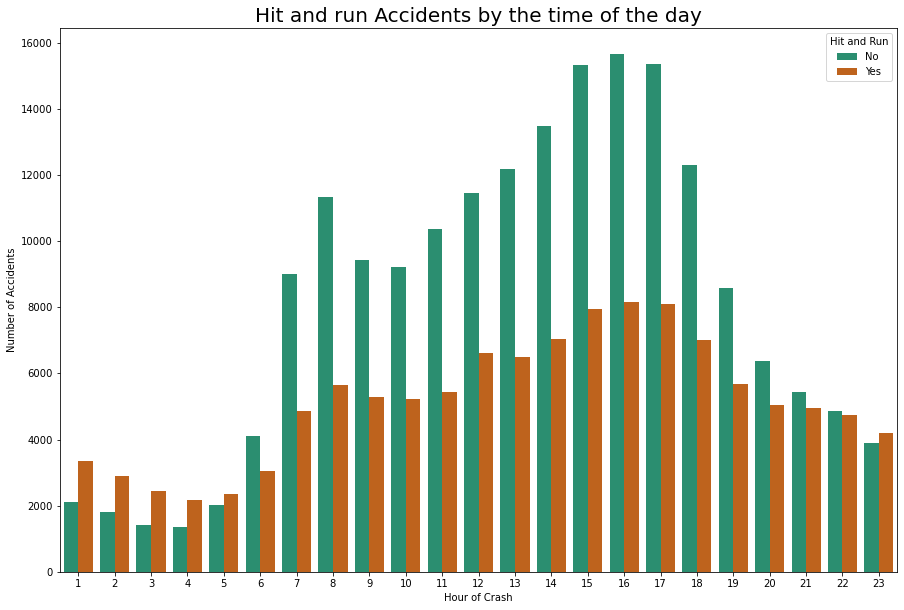

In [35]:
plt.figure(figsize =(15,10))
ax = sns.countplot(x="CRASH_HOUR",hue='HIT_AND_RUN_I',data=df_clean,order = range(1,24),palette='Dark2')
plt.xlabel('Hour of Crash')
plt.ylabel('Number of Accidents')
plt.legend(title='Hit and Run', loc='upper right', labels=['No', 'Yes'])
plt.title('Hit and run Accidents by the time of the day',size=20)
plt.show()

Injury resulting hit and runs follow pretty much the same distribution as accidents in general with peaks around rush hour.

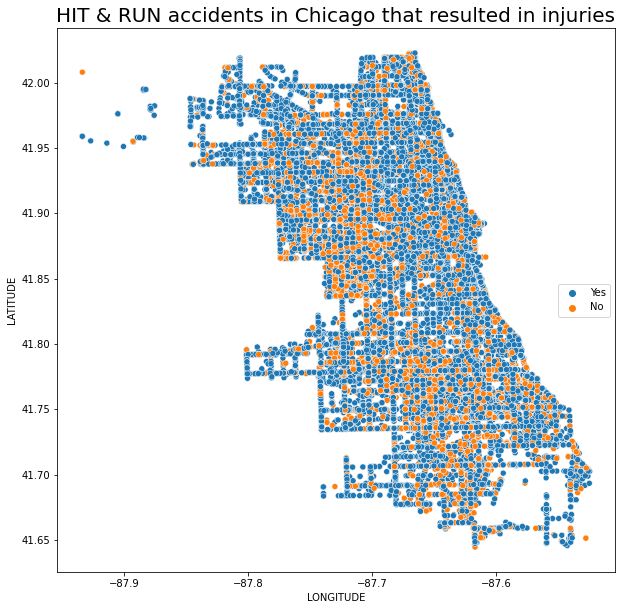

In [36]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='LONGITUDE', y='LATITUDE', hue='HIT_AND_RUN_I', data=df_injury)
plt.title('HIT & RUN accidents in Chicago that resulted in injuries',size=20)
handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, ['Yes', 'No'], loc='center right')
plt.show()

Hit and Run are pretty well spread out with only small noticaeble clusters passing thru lat 41.9

In [37]:
df_injury.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39847 entries, 7 to 312608
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   POSTED_SPEED_LIMIT       39847 non-null  int64  
 1   TRAFFIC_CONTROL_DEVICE   39847 non-null  object 
 2   DEVICE_CONDITION         39847 non-null  object 
 3   WEATHER_CONDITION        39847 non-null  object 
 4   LIGHTING_CONDITION       39847 non-null  object 
 5   FIRST_CRASH_TYPE         39847 non-null  object 
 6   TRAFFICWAY_TYPE          39847 non-null  object 
 7   ALIGNMENT                39847 non-null  int64  
 8   ROAD_DEFECT              39847 non-null  int64  
 9   CRASH_TYPE               39847 non-null  int64  
 10  INTERSECTION_RELATED_I   39847 non-null  int64  
 11  NOT_RIGHT_OF_WAY_I       39847 non-null  int64  
 12  HIT_AND_RUN_I            39847 non-null  int64  
 13  DOLLAR_DAMAGE            39847 non-null  object 
 14  PRIM_CONTRIBUTORY_CAU

## Setup data for modelling 

In [38]:
# df=df_clean.copy() #All Causes , All accident types
# df=top5.copy() #Top5 types of accidents
df=df_injury.copy() # Accident with injuries
# df=df_top10_causes.copy() # Top 10 causes of accidents 
# df=df_top5_causes.copy() # Top 5 causes of accidents 
# df=df_top3_causes.copy() # Top 3 causes of accidents 


In [39]:
#Filter string data
categorical_list = df.columns[(df.dtypes.values == np.dtype('object'))]
# categorical_list = df_clean.columns[(df_clean.dtypes.values == np.dtype('object'))]
categorical_list

Index(['TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
       'DOLLAR_DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE', 'INJURY_TYPE'],
      dtype='object')

In [40]:
#Convert string categoricals into dummy numerical values 
# df_en = df.copy()
# for col in categorical_list:
#     encoder = LabelEncoder()
#     df_en[col] = encoder.fit_transform(df_en[col])
df_en = pd.get_dummies(df, drop_first=True)        

In [41]:
# df_en.info()

In [42]:
#  df_en.head()

In [43]:
# Set Predictor and response  
y = df_en['HIT_AND_RUN_I']
X = df_en.drop('HIT_AND_RUN_I', axis=1)
        

In [44]:
#Normalize
# Fill missing values
X = X.fillna(value=0) 
for col in X.columns:
    # Subtract the minimum and divide by the range forcing a scale of 0 to 1 for each feature
    X[col] = (X[col] - min(X[col]))/ (max(X[col]) - min(X[col])) 

X.head()

,POSTED_SPEED_LIMIT,ALIGNMENT,ROAD_DEFECT,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,NUM_UNITS,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,...,PRIM_CONTRIBUTORY_CAUSE_IMPROPER BACKING,PRIM_CONTRIBUTORY_CAUSE_IMPROPER LANE USAGE,PRIM_CONTRIBUTORY_CAUSE_IMPROPER OVERTAKING/PASSING,PRIM_CONTRIBUTORY_CAUSE_IMPROPER TURNING/NO SIGNAL,"PRIM_CONTRIBUTORY_CAUSE_OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER",PRIM_CONTRIBUTORY_CAUSE_UNKNOWN_HR,PRIM_CONTRIBUTORY_CAUSE_WEATHER,INJURY_TYPE_INCAPACITATING INJURY,INJURY_TYPE_NONINCAPACITATING INJURY,"INJURY_TYPE_REPORTED, NOT EVIDENT"
7,0.4,1.0,0.0,1.0,0.0,0.0,0.25,0.826087,0.333333,0.363636,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14,0.6,1.0,0.0,1.0,0.0,0.0,0.25,0.739130,1.000000,0.909091,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16,0.6,1.0,0.0,1.0,1.0,0.0,0.25,0.565217,1.000000,0.636364,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
40,0.6,1.0,0.0,1.0,0.0,0.0,0.25,1.000000,0.500000,0.727273,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
41,0.0,1.0,0.0,1.0,0.0,0.0,0.25,0.347826,0.500000,0.727273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [45]:
#Create training/testing data with 30 % test data
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


In [46]:
# X_train.info()

# Modelling

## Vanilla model: Decision tree classifier (DTC) iteration 

In [47]:

DTC_model1 = DecisionTreeClassifier(random_state=42)


In [48]:
# DTC_model1

In [49]:
DTC_model1.fit(X_train, y_train)
;

''

In [50]:
y_test_pred = DTC_model1.predict(X_test)

In [51]:
#Report performance
get_metrics(y_test, y_test_pred)


F1 Score: 0.7503491274187802
Accuracy Score Test: 0.7488080301129235
ROC_AUC Test: 0.6882599145891549


In [52]:
# look most important features 
# DTC_model1.feature_importances_

In [53]:
# Look at the feature contribution to our model.
importances = DTC_model1.feature_importances_
indices = np.argsort(importances)[::-1]
drop_feature_list=[]
# Print the feature ranking
print("Feature ranking:")
for i in range(X_train.shape[1]):
    print(i + 1, X_train.columns[indices[i]], importances[indices[i]])
    if importances[indices[i]]< 0.01:
        drop_feature_list.append(X_train.columns[indices[i]])#track features that contribute less than 1%

Feature ranking:
1 PRIM_CONTRIBUTORY_CAUSE_UNKNOWN_HR 0.3377096521723981
2 LATITUDE 0.12189718855019838
3 LONGITUDE 0.11683578374051679
4 CRASH_HOUR 0.05928431168447734
5 CRASH_MONTH 0.05206250194623634
6 CRASH_DAY_OF_WEEK 0.041056268228422274
7 POSTED_SPEED_LIMIT 0.02092505093862555
8 NUM_UNITS 0.01595589722512359
9 FIRST_CRASH_TYPE_PEDESTRIAN 0.013331032980737583
10 PRIM_CONTRIBUTORY_CAUSE_OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER 0.011466342526191473
11 TRAFFICWAY_TYPE_DIVIDED 0.011017172502173237
12 INTERSECTION_RELATED_I 0.010374108896489029
13 TRAFFICWAY_TYPE_NOT DIVIDED 0.010278265121305518
14 DEVICE_CONDITION_NO CONTROLS 0.009669394257701577
15 TRAFFIC_CONTROL_DEVICE_SIGNAL 0.008630086886923282
16 INJURY_TYPE_REPORTED, NOT EVIDENT 0.008447213887043557
17 INJURY_TYPE_NONINCAPACITATING INJURY 0.00840822516079704
18 WEATHER_CONDITION_RAIN 0.007869995843310168
19 DOLLAR_DAMAGE_OVER 1500 0.0069453585846882705
20 PRIM_CONTRIBUTORY_CAUSE_FOLLOWIN

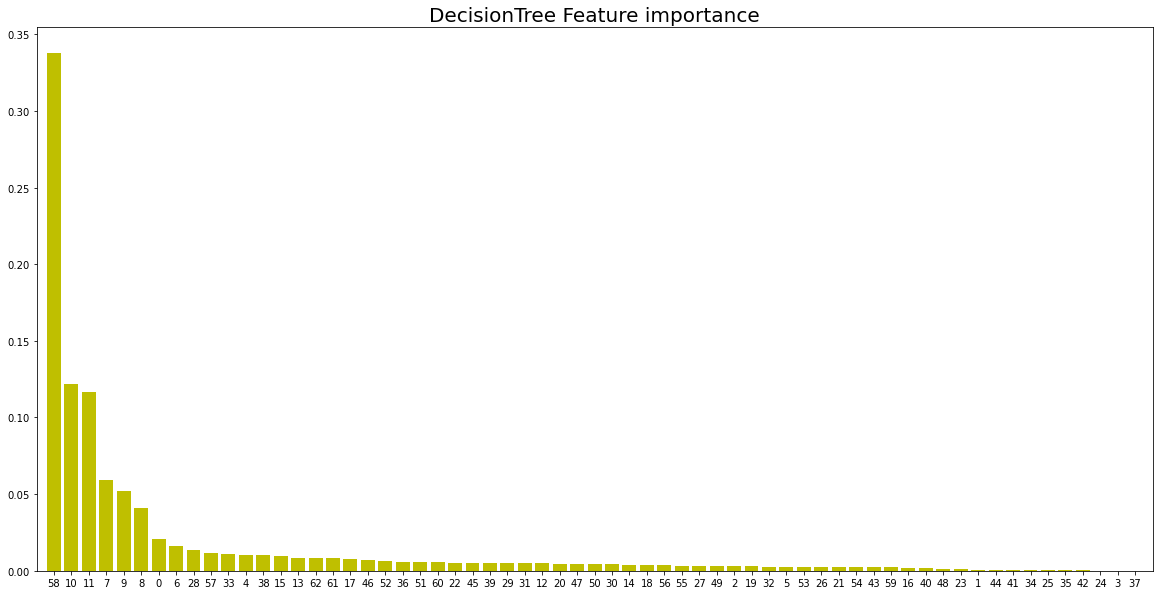

In [54]:
# Plot the feature importances 
plt.figure(figsize=(20,10))
plt.title("DecisionTree Feature importance",size=20)
plt.bar(range(X_train.shape[1]), importances[indices],color="y", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()


Makes sense that the prim cause has a big impact on hit and run accidents , Intrestingly location has a big impact as well so perhaps we should expolore this, Lastly the hour is also among the top 5 feature along with hit and run.

In [55]:
# drop_feature_list

Based on the first instance of our DTC model it seems there are lot of features that are barely contributing to the model (<1%) . Before we start to get rid of some of the features perhaps we should check to see if there is any class imbalance issues. 

## DTC with SMOTE data and stratified cross validation

 Rectify class imbalance using smote

In [56]:
# summarize distribution
counter = Counter(y)
for j,k in counter.items():
    per = k / len(y) * 100
    print('n=%d HR: %s, (%.3f%%)' % ( k,j, per))
# plot the distribution
# pyplot.bar(counter.keys(), counter.values())
# pyplot.show()

n=28945 HR: 0, (72.640%)
n=10902 HR: 1, (27.360%)


Our classes are are not completely balanced but they are not too bad either, but to assure there is no class imbalance we can generate synthethic data using smote as seen down below.

In [57]:
# oversampling minority class and undersampling majority class
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# summarize distribution
counter = Counter(y_train_resampled)
for j,k in counter.items():
    per = k / len(y_train_resampled) * 100
    print('n=%d %s, (%.3f%%)' % ( k,j, per))
# plot the distribution
# pyplot.bar(counter.keys(), counter.values())
# pyplot.show()

C:\Users\Laurel\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


n=20226 0, (50.000%)
n=20226 1, (50.000%)


Now that we have SMOTE data we should try using stratified cross validation to assure sampling is not an issue .

In [58]:
#We will use three repeats of 10-fold cross-validation,
#4-fold cross-validation is applied 5 times fitting and evaluating 20 models on the dataset.
DTC_model2 = DecisionTreeClassifier(random_state=42)
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=5, random_state=42)
cv_scores = cross_val_score(DTC_model2,X_train_resampled, y_train_resampled, scoring='accuracy', cv=cv, n_jobs=-1)
#Check the mean Accuracy score of the 20 models 
print('Accuracy: %.3f (%.3f)' % (mean(cv_scores), std(cv_scores)))

Accuracy: 0.806 (0.005)


Cross validation on smote data  improved the accuracy by about 6% class imbalance in our data has a resonable effect on our model. Now we can look at features to see if we have redundant features that are not helping our model perhaps this will improve our model accuracy since in our feature ranking we saw several features contribute less than 1 % to our model .

## DTC with RFECV  on smote data

In [59]:
# Using RFECV look at the cross-validated score performance for the training data
DTC_model3 = DecisionTreeClassifier(random_state=42)
# The "accuracy" scoring translates to correct classifications in training data folds
rfecv = RFECV(estimator=DTC_model3, step=1, cv=cv,scoring='accuracy')
rfecv.fit(X_train_resampled, y_train_resampled)
;

''

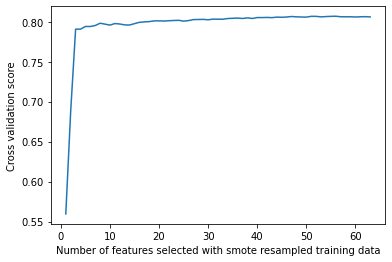

In [60]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected with smote resampled training data")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [61]:
# features to keep /remove based on training data and RFECV
columns_keep_3=[]
print("Optimal number of features : %d" % rfecv.n_features_)
for i in range(X_train.shape[1]):
    if rfecv.support_[i] ==True:
        print('Column %.f,Feature to keep: %s, Selected %s, Rank: %.3f' % (i,X_train.columns[i], rfecv.support_[i], rfecv.ranking_[i]))
        columns_keep_3.append(i)

Optimal number of features : 56
Column 0,Feature to keep: POSTED_SPEED_LIMIT, Selected True, Rank: 1.000
Column 1,Feature to keep: ALIGNMENT, Selected True, Rank: 1.000
Column 2,Feature to keep: ROAD_DEFECT, Selected True, Rank: 1.000
Column 4,Feature to keep: INTERSECTION_RELATED_I, Selected True, Rank: 1.000
Column 5,Feature to keep: NOT_RIGHT_OF_WAY_I, Selected True, Rank: 1.000
Column 6,Feature to keep: NUM_UNITS, Selected True, Rank: 1.000
Column 7,Feature to keep: CRASH_HOUR, Selected True, Rank: 1.000
Column 8,Feature to keep: CRASH_DAY_OF_WEEK, Selected True, Rank: 1.000
Column 9,Feature to keep: CRASH_MONTH, Selected True, Rank: 1.000
Column 10,Feature to keep: LATITUDE, Selected True, Rank: 1.000
Column 11,Feature to keep: LONGITUDE, Selected True, Rank: 1.000
Column 12,Feature to keep: TRAFFIC_CONTROL_DEVICE_SIGN, Selected True, Rank: 1.000
Column 13,Feature to keep: TRAFFIC_CONTROL_DEVICE_SIGNAL, Selected True, Rank: 1.000
Column 14,Feature to keep: TRAFFIC_CONTROL_DEVICE_U

In [62]:
y_test_pred=rfecv.predict(X_test)

In [63]:
#Report performance
get_metrics(y_test, y_test_pred)


F1 Score: 0.7408439731881712
Accuracy Score Test: 0.7370974487662066
ROC_AUC Test: 0.6826606138846


Our model used 56 out of 63 features for its classification and ACcuracy actually went down. It seems model accuracy increases very slowly past 5 features. This makes sense since the top 5 features are the most prominent as they contrbute almost 65-70% of our models ability to classify. This suggests for the data we have at hand with the number of features and target classes, our model cant perform any better. Perhaps to increase accuracy we need more data. That is not possible at this time since the data portal of chicago only has data going back to 2013 accessible to the general public .

We can see that automatically selecting features and then fitting a decision tree on the selected features gives us a classification accuracy close to 74 percent. Perhaps tuning the model hyperparameters will increase the acuracy a bit more.

## Hyperparameter tuning using Grid Search

In [64]:
# criterion : "gini", "entropy"
# max_depth : The maximum depth of the tree.
# min_samples_split : The minimum number of samples required to split an internal node:
# min_samples_leaf : The minimum number of samples required to be at a leaf node. 
parameters = {"criterion": ["gini", "entropy"],
              "max_depth": [2,4,6,8,10,12],
              "splitter":["best","random"],
             "max_features":list(range(0,23)),
             "class_weight":["balanced", "None"]}
DTC_model4 =DecisionTreeClassifier()
grid_search = GridSearchCV(DTC_model4, parameters, n_jobs=-1, cv=cv, scoring='roc_auc')
grid_search.fit(X_train_resampled, y_train_resampled)
;

''

In [65]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 12, 'max_features': 21, 'splitter': 'best'}
0.8496108093994288


So seems the model will perform best when the classes weights are balanced and criterion is based on entropy metric with a max depth of 12. It makes sense the max features is 12 since the optimal number of features recommended using RFECV with stratified and repeated stratified flatten out around 12 .Using best splitter parameter means the model is taking the feature with the highest importance instead of randomly splitting.


In [66]:
y_test_pred = grid_search.best_estimator_.predict(X_test)

In [67]:
#Report performance
get_metrics(y_test, y_test_pred)


F1 Score: 0.7793908195504002
Accuracy Score Test: 0.7816813048933501
ROC_AUC Test: 0.7136147085680633


Hyperparameter tuning resulted in better performancy metrics, The  Accuracy is over 80%  and the Higher F1 means the balance between precesion and recall was improved as well

## Meta Estimators

### Baggling classifier 

We will now fit a decision tree classifier  on random subsets of the original training data using bagging classifier

In [68]:
# Instantiate a BaggingClassifier
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=12), 
                                 n_estimators=20)

In [69]:
bagged_tree.fit(X_train_resampled, y_train_resampled)
;

''

In [70]:
# Testing accuracy score
y_test_pred = bagged_tree.predict(X_test)

In [71]:
#Report performance
get_metrics(y_test, y_test_pred)


F1 Score: 0.8112933333765574
Accuracy Score Test: 0.8265161020493518
ROC_AUC Test: 0.718797594897749


Accuracy is higher and so is the F1 score and ROC_AUC which suggests that there was some variance involved while using the decision tree classfier

### Random forest classfier 

In [72]:
# Instantiate and fit a RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth= 12)
forest.fit(X_train_resampled, y_train_resampled)
;

''

In [73]:
y_test_pred = forest.predict(X_test)

In [74]:
#Report performance
get_metrics(y_test, y_test_pred)


F1 Score: 0.8187039991981011
Accuracy Score Test: 0.8324550397323296
ROC_AUC Test: 0.7292821000582534


### Random forest with RFECV

In [75]:
# Using RFECV look at the cross-validated score performance for the training data
# The "accuracy" scoring translates to correct classifications in training data folds
rfecv = RFECV(estimator=forest, step=1, cv=StratifiedKFold(n_splits=5),scoring='accuracy')
rfecv.fit(X_train_resampled, y_train_resampled)
;

''

In [76]:
# features to keep /remove based on training data and RFECV
print("Optimal number of features : %d" % rfecv.n_features_)
for i in range(X_train.shape[1]):
    if rfecv.support_[i] ==True:
        print('Column %.f,Feature to keep: %s, Selected %s, Rank: %.3f' % (i,X_train.columns[i], rfecv.support_[i], rfecv.ranking_[i]))
        

Optimal number of features : 4
Column 0,Feature to keep: POSTED_SPEED_LIMIT, Selected True, Rank: 1.000
Column 6,Feature to keep: NUM_UNITS, Selected True, Rank: 1.000
Column 9,Feature to keep: CRASH_MONTH, Selected True, Rank: 1.000
Column 58,Feature to keep: PRIM_CONTRIBUTORY_CAUSE_UNKNOWN_HR, Selected True, Rank: 1.000


As suspected by the feature importance Random forest classifier is using the only the top 4 features. Also it makes sense that speed limit and prim cause are the most prominent features.

In [77]:
y_test_pred=rfecv.predict(X_test)

In [78]:
#Report performance
get_metrics(y_test, y_test_pred)


F1 Score: 0.8099031881862289
Accuracy Score Test: 0.8367210372229192
ROC_AUC Test: 0.6988789064587787


The  Accuracy is nearly 84%  and  F1 score has improved as well which means the balance between precesion and recall was improved.

# Conclusion and Future work


The Random forest classifier has the highest ROC_AUC and F1 score. The Accuracy score is about 83.3% which is not the highest but its more reliable than the other models. One of the things i would like to do in the future is section the city into smaller parts to determine hot spots of hit and run accidents. Also I would like to focus more on the top 5 type of accidents as they acount for 95 % of all accidents and determine if they result in hit and run cases that result in injuries  